In this verion all expert sees all data, then we assigne importance to the random initialization of the networks (experts) during the training and bix the distributions based on these importances (probs). We repeat it for every model and then mix the models distribution with equal weights.

Key imps:

- log pareto mixure assumbed for the log des volume
- more complex latent dist
- more komplex experts (not regressions but neural networks) 
ect.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import *
import os
from datasets import load_dataset
import pandas as pd
import numpy as np
import datetime
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import Softmax
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import pareto, norm
from utils_1 import read_txn_data, preprocess_txn_data, create_lob_dataset, merge_txn_and_lob
import numpy as np
import torch
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
import properscoring as ps
import matplotlib.pyplot as plt
from numpy import sqrt
from utils import read_txn_data, preprocess_txn_data, compute_lob_features, create_lob_dataset, merge_txn_and_lob

c:\Users\peter\anaconda3\envs\torch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
freq='5min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df = merge_txn_and_lob(trx_df, lob_df,freq)
# Compute threshold
mean_volume = trx_df['deseasoned_total_volume'].mean()
std_volume = trx_df['deseasoned_total_volume'].std()
threshold = mean_volume + 10*std_volume
# Identify high volume periods
high_volume = trx_df[trx_df['deseasoned_total_volume'] > threshold]
print(trx_df['deseasoned_total_volume'].max())
print(len(high_volume))
# drop high volume observations
#trx_df = trx_df[trx_df['deseasoned_total_volume'] <= threshold]
#replace high volume with 1 and low volume with 0
#trx_df['log_deseasoned_total_volume'] = np.where(trx_df['deseasoned_total_volume'] > threshold, 1, 0)
df = merge_txn_and_lob(trx_df, lob_df,freq)

trx Data loaded successfully.
preprocessed lob Data loaded successfully.
40.10633102518099
39


In [3]:
df

,datetime,buy_volume,sell_volume,buy_txn,sell_txn,volume_imbalance,txn_imbalance,total_volume,mean_volume,deseasoned_total_volume,...,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10,spread,lob_volume_imbalance,slope_imbalance_1,slope_imbalance_5,slope_imbalance_10
1163,2018-06-04 22:00:05+00:00,4.110453,4.175295,95.0,30.0,0.064842,65.0,8.285749,29.244585,0.283326,...,2695.804973,2695.804973,3.972121,53.502450,160.246934,6.19,583660.308720,1757.658546,2642.302523,2535.558040
1164,2018-06-04 22:05:05+00:00,0.579045,3.373552,15.0,17.0,2.794507,2.0,3.952597,22.893149,0.172654,...,2646.609837,2646.609837,2.240304,42.838426,160.030834,4.33,583661.392527,1711.511509,2603.771411,2486.579003
1165,2018-06-04 22:10:05+00:00,0.935114,7.605058,49.0,29.0,6.669943,20.0,8.540172,28.912804,0.295377,...,2692.780308,2692.780308,3.398417,122.784273,230.739393,4.72,583655.379845,1699.678930,2569.996035,2462.040915
1166,2018-06-04 22:15:05+00:00,2.138732,2.397898,61.0,28.0,0.259166,33.0,4.536630,23.005778,0.197195,...,2684.584582,2684.584582,47.170901,194.070903,258.553253,1.26,583691.569579,1626.190532,2490.513679,2426.031329
1167,2018-06-04 22:20:05+00:00,11.773303,5.162054,94.0,16.0,6.611249,78.0,16.935358,24.074095,0.703468,...,2691.271950,2691.271950,40.175665,134.230252,283.772371,0.39,583700.897483,1619.139947,2557.041699,2407.499579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34962,2018-09-30 21:40:05+00:00,16.933169,0.217044,41.0,2.0,16.716125,39.0,17.150213,34.548421,0.496411,...,2884.331180,2884.331180,92.618876,144.092581,241.693608,6.79,499192.148616,1694.435811,2740.238599,2642.637572
34963,2018-09-30 21:45:05+00:00,2.693770,0.969224,14.0,5.0,1.724547,9.0,3.662994,24.414627,0.150033,...,2884.686299,2884.686299,93.478131,144.295761,207.556483,5.89,499195.196647,1693.960199,2740.390538,2677.129816
34964,2018-09-30 21:50:05+00:00,1.377229,0.974653,15.0,8.0,0.402576,7.0,2.351881,29.509068,0.079700,...,2856.043529,2856.043529,84.135558,130.467587,195.550423,5.58,499172.120858,1682.518944,2725.575942,2660.493106
34965,2018-09-30 21:55:05+00:00,5.615628,2.031659,17.0,11.0,3.583969,6.0,7.647286,24.549364,0.311506,...,2804.837578,2804.837578,95.243968,145.303291,235.965279,3.86,499262.351042,1612.335641,2659.534287,2568.872299


3. Log-Normal-Pareto Composite Distribution (LNP)

A custom distribution class that mixes:
- Log-Normal (for "small" values, below a threshold)
- Pareto (for "large" tail events)

Key pieces:
1. Parameters
- mu, sigma (log-normal)
- alpha, threshold (Pareto tail)
- A learned mixing weight ( lognorm_weight ) constrained between 0.1 and 0.9.
2. log_pdf(x)
- Computes log-density of the mixture:

$$
\log \left(w p_{\mathrm{LN}}(x) 1_{x<\log (\mathrm{th})}+(1-w) p_{\text {Pareto }}(x) 1_{x \geq \log (\mathrm{th})}\right)
$$

- Clamps outputs for numerical stability.

In [4]:
train_size_fix = 0.9
val_size_fix = 0.1

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# —————————————————————————————
# 1. Deseasonalization helper (unchanged)
# —————————————————————————————
def recalc(df: pd.DataFrame, train_size=train_size_fix) -> pd.DataFrame:
    df['time'] = df['datetime'].dt.time
    split = train_test_split(df, train_size=train_size, shuffle=False)
    a = split[0].shape[0]
    train = df.iloc[:a].copy()
    train['mean_volume'] = train.groupby('time')['total_volume'].transform('mean')
    train['deseasoned_total_volume'] = train['total_volume'] / train['mean_volume']
    train['log_deseasoned_total_volume'] = np.log(train['deseasoned_total_volume'])
    rest = df.iloc[a:].copy()
    trange = pd.date_range("00:00:05", "23:59:05", freq='1min').time
    for t in trange:
        if (t in rest['time'].values) and (t in train['time'].values):
            rest.loc[rest['time']==t,'mean_volume'] = \
             train.loc[train['time']==t,'mean_volume'].iat[0]


    return pd.concat([train,rest])

# —————————————————————————————
# 2. Dataset (unchanged)
# —————————————————————————————
class CustomDataset(Dataset):
    def __init__(self, df, h):
        self.trx = torch.tensor(df[['buy_volume','sell_volume','buy_txn','sell_txn','volume_imbalance','txn_imbalance']].to_numpy())
        self.lob = torch.tensor(df[['ask_volume','bid_volume','spread','lob_volume_imbalance',
                                    'ask_slope_1','ask_slope_5','ask_slope_10',
                                    'bid_slope_1','bid_slope_5','bid_slope_10','spread']].to_numpy())
        y = df['log_deseasoned_total_volume'].to_numpy()
        self.y_mean = np.mean(y[np.isfinite(y)])
        self.y_std = np.std(y[np.isfinite(y)])
        y = (y - self.y_mean) / self.y_std
        self.y = torch.tensor(y)
        self.h = h

    def __len__(self):
        return len(self.y) - self.h

    def __getitem__(self, idx):
        trx = self.trx[idx:idx+self.h]  # (h,6)
        lob = self.lob[idx:idx+self.h]  # (h,10)
        label = self.y[idx+self.h]      # scalar
        return trx, lob, label

# —————————————————————————————
# 3. Log-Normal–Pareto composite (unchanged)
# —————————————————————————————
class LNP:
    def __init__(self, mu, sigma, alpha, threshold):
        self.mu = mu
        self.sigma = sigma
        self.alpha = alpha
        self.threshold = threshold
        self.lognorm_weight = nn.Parameter(torch.tensor(0.5, device=mu.device, dtype=mu.dtype))

    def log_pdf(self, x, eps=1e-6):
        x = x.expand(-1, 2)
        lognorm = -0.5 * torch.log(2 * np.pi * self.sigma**2) - (x - self.mu)**2 / (2 * self.sigma**2)
        pareto_log = torch.log(self.alpha) + self.alpha * torch.log(self.threshold) - (self.alpha + 1) * x
        indicator = (x < torch.log(self.threshold)).float()
        eps_tensor = torch.tensor(eps, device=x.device, dtype=x.dtype)
        w = torch.clamp(self.lognorm_weight, 0.1, 0.9)
        log_pdf = torch.log(w + eps_tensor) + lognorm * indicator + \
                  torch.log(1 - w + eps_tensor) + pareto_log * (1 - indicator)
        return log_pdf.clamp(min=-100, max=100)

# —————————————————————————————
# 4. Expert & Mixture modules (unchanged)
# —————————————————————————————
class latent_dist(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(h * (6 + 11), 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
        )
        self.soft = nn.Softmax(dim=1)

    def forward(self, trx, lob):
        b = trx.size(0)
        trx_flat = trx.permute(0,2,1).reshape(b, -1)
        lob_flat = lob.permute(0,2,1).reshape(b, -1)
        scores = self.mlp(torch.cat((trx_flat, lob_flat), dim=1))
        return self.soft(scores)

class lnp_expert(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.trx_net = nn.Sequential(
            nn.Linear(h * 6, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
        )
        self.lob_net = nn.Sequential(
            nn.Linear(h * 11, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
        )
        self.mean_head = nn.Linear(64,1)
        self.var_head  = nn.Linear(64,1)
        self.alpha_head = nn.Linear(64,1)
        self.threshold = nn.Parameter(torch.tensor(0.0))
        nn.init.normal_(self.mean_head.weight, mean=0, std=0.01)
        nn.init.normal_(self.var_head.weight,  mean=0, std=0.01)
        nn.init.normal_(self.alpha_head.weight,mean=0, std=0.01)

    def forward(self, trx, lob):
        b = trx.size(0)
        trx_flat = trx.permute(0,2,1).reshape(b, -1)
        lob_flat = lob.permute(0,2,1).reshape(b, -1)
        f1 = self.trx_net(trx_flat)
        f2 = self.lob_net(lob_flat)
        comb = torch.cat((f1,f2), dim=1)
        
        mean = self.mean_head(comb)
        var  = torch.clamp(torch.exp(self.var_head(comb)), min=1e-4, max=10.0)
        alpha = torch.clamp(torch.exp(self.alpha_head(comb)), min=0.1, max=10.0)
        thresh = torch.clamp(torch.exp(self.threshold), min=0.1, max=5.0)
        
        # Expand to (batch,2) so each expert uses same params
        return mean.expand(-1,2), var.expand(-1,2), alpha.expand(-1,2), thresh

# —————————————————————————————
# 5. Simplified mixture model (no hurdle)
# —————————————————————————————
class TME(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.expert = lnp_expert(h)
        self.latent = latent_dist(h)

    def forward(self, trx, lob):
        mean, var, alpha, threshold = self.expert(trx, lob)
        prob = self.latent(trx, lob)
        return mean, var, alpha, threshold, prob

# —————————————————————————————
# 6. New loss: pure mixture log‐likelihood
# —————————————————————————————
def LNP_mixture_loss(pred, target, eps=1e-6):
    mean, var, alpha, threshold, prob = pred
    y = target.unsqueeze(1)  # → (batch,1)
    lnp = LNP(mean, torch.sqrt(var), alpha, threshold)
    log_pdf = lnp.log_pdf(y, eps=eps)  # (batch,2)
    mix_ll = torch.sum(log_pdf * prob, dim=1)  # (batch,)
    return -mix_ll.mean()

# —————————————————————————————
# 7. Data loading & training loop (unchanged aside from loss call)
# —————————————————————————————
#trx_df = read_txn_data(use_load=False)
#lob_df = create_lob_dataset(use_load=False)
#trx_df = preprocess_txn_data(trx_df, freq='1min', fill_missing_ts=False)
#df = merge_txn_and_lob(trx_df, lob_df)

# Fill NaNs/Infs
if df.isna().any().any():
    df = df.fillna(0)
df['log_deseasoned_total_volume'] = (
    df['log_deseasoned_total_volume']
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)


train_val, test_df = train_test_split(df, train_size=0.9, shuffle=False)
train_df, val_df = train_test_split(train_val, train_size=0.9, shuffle=False)


print(f"Total: {len(df)}")
print(f"Train: {len(train_df)}")
print(f"Val:   {len(val_df)}")
print(f"Test:  {len(test_df)}")

h = 100
lr = 1e-3
batch_size = 128
epochs = 1
Lambda = 0.1

# Standardize inputs
mu, sigma = train_df.iloc[:,1:].mean(), train_df.iloc[:,1:].std()
train_ds = CustomDataset((train_df.iloc[:,1:]-mu)/sigma, h)
val_ds   = CustomDataset((val_df.iloc[:,1:]-mu)/sigma, h)
test_ds  = CustomDataset((test_df.iloc[:,1:]-mu)/sigma, h)
train_loader = DataLoader(train_ds, batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size, shuffle=False)

# Ensemble setup
n_models    = 5
models      = [TME(h).double() for _ in range(n_models)]
optimizers  = [torch.optim.Adam(m.parameters(), lr=lr, weight_decay=Lambda)
               for m in models]
schedulers  = [torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min',
                                                          factor=0.5, patience=5)
               for opt in optimizers]

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    for mi, (model, opt) in enumerate(zip(models, optimizers)):
        model.train()
        total_loss = 0.0
        for i, (trx_b, lob_b, y) in enumerate(train_loader):
            trx_b = trx_b.permute(0,2,1)
            lob_b = lob_b.permute(0,2,1)

            pred = model(trx_b, lob_b)
            loss = LNP_mixture_loss(pred, y)
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            opt.zero_grad()

            if i % 100 == 0:
                print(f" Model {mi} Batch {i}: Loss={loss.item():.4f}")

        avg_train = total_loss / len(train_loader)
        print(f" Model {mi} Train Loss: {avg_train:.4f}")

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for trx_b, lob_b, y_b in test_loader:
                trx_b = trx_b.permute(0,2,1)
                lob_b = lob_b.permute(0,2,1)
                test_loss += LNP_mixture_loss(model(trx_b, lob_b), y_b).item()
        avg_test = test_loss / len(test_loader)
        print(f" Model {mi} Test Loss: {avg_test:.4f}")

        schedulers[mi].step(avg_test)

def ensemble_predict(models, trx, lob):
    with torch.no_grad():
        log_liks = []
        for m in models:
            m.eval()
            mean, var, alpha, threshold, prob = m(trx, lob)
            lnp = LNP(mean, torch.sqrt(var), alpha, threshold)
            log_pdf = lnp.log_pdf(torch.zeros_like(mean))
            #log_lik = torch.sum(log_pdf * prob, dim=1)
            eps= 1e-6
            log_lik = torch.logsumexp(log_pdf + torch.log(prob + eps), dim=1) # MIXING EXPERTS!!!!!
            log_liks.append(log_lik)
        return torch.mean(torch.stack(log_liks), dim=0) # MIXING MIXTURES WITH EQAUL WEIGHTING


with torch.no_grad():
    for trx_b, lob_b, _ in test_loader:
        trx_b = trx_b.permute(0,2,1)
        lob_b = lob_b.permute(0,2,1)
        ens_ll = ensemble_predict(models, trx_b, lob_b)
        print(f"Ensemble log-likelihood: {ens_ll.mean().item():.4f}")
        break


Total: 31187
Train: 25261
Val:   2807
Test:  3119

Epoch 1/1
 Model 0 Batch 0: Loss=2.8233
 Model 0 Batch 100: Loss=2.5303
 Model 0 Train Loss: 2.7177
 Model 0 Test Loss: 2.6357
 Model 1 Batch 0: Loss=2.8295
 Model 1 Batch 100: Loss=2.5586
 Model 1 Train Loss: 2.7031
 Model 1 Test Loss: 2.6304
 Model 2 Batch 0: Loss=2.8282
 Model 2 Batch 100: Loss=2.5390
 Model 2 Train Loss: 2.7345
 Model 2 Test Loss: 2.6323
 Model 3 Batch 0: Loss=2.8379
 Model 3 Batch 100: Loss=2.5391
 Model 3 Train Loss: 2.7636
 Model 3 Test Loss: 2.6518
 Model 4 Batch 0: Loss=2.8260
 Model 4 Batch 100: Loss=2.5336
 Model 4 Train Loss: 2.7239
 Model 4 Test Loss: 2.6335
Ensemble log-likelihood: -2.7704


tensor([[0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5002, 0.4998],
        [0.5

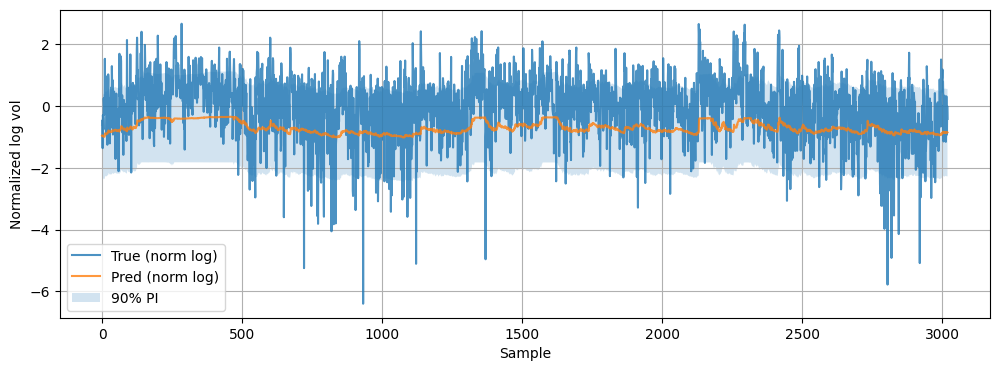

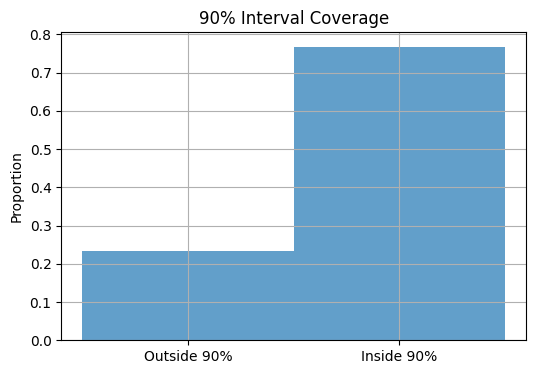

In [6]:
import numpy as np
import torch
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
import properscoring as ps
import matplotlib.pyplot as plt

# --- initialize accumulators ---
y_trues = []
y_preds = []
lower_intervals = []
upper_intervals = []
log_likelihoods = []
vars_list = []

# --- evaluation loop ---
model.eval()
with torch.no_grad():
    for trx_batch, lob_batch, y in test_loader:
        trx_b = trx_batch.permute(0,2,1)
        lob_b = lob_batch.permute(0,2,1)

        # forward pass: now returns mean, var, alpha, threshold, prob
        mean, var, alpha, threshold, prob = model(trx_b, lob_b)

        # 1) Point prediction = mixture expectation of log-volume
        pred_log = torch.sum(mean * prob, dim=1)
        print(prob)

        # 2) Mixture variance for prediction intervals:
        #    Var[Y] = E[σ² + μ²] - (E[μ])²
        second_moment = torch.sum(prob * (var + mean**2), dim=1)
        mixture_var = second_moment - pred_log**2
        mixture_std = torch.sqrt(torch.clamp(mixture_var, min=1e-6))

        # 90% Gaussian approx interval
        z = norm.ppf(0.95)
        lower = pred_log - z * mixture_std
        upper = pred_log + z * mixture_std

        # 3) Log-likelihood under the LNP mixture
        lnp = LNP(mean, torch.sqrt(var), alpha, threshold)
        log_pdf = lnp.log_pdf(y.unsqueeze(1))        # (batch,2)
        mix_ll = torch.sum(log_pdf * prob, dim=1)    # (batch,)
        
        # collect
        y_trues.append(y.cpu().numpy())
        y_preds.append(pred_log.cpu().numpy())
        lower_intervals.append(lower.cpu().numpy())
        upper_intervals.append(upper.cpu().numpy())
        log_likelihoods.append(mix_ll.cpu().numpy())
        vars_list.append(var.cpu().numpy())

# --- stack / concat ---
y_true = np.concatenate(y_trues)
y_pred = np.concatenate(y_preds)
lower  = np.concatenate(lower_intervals)
upper  = np.concatenate(upper_intervals)
log_likelihoods = np.concatenate(log_likelihoods)
var = np.concatenate(vars_list, axis=0)

print(f"y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}, var shape: {var.shape}")

# --- metrics ---
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
nll  = -np.mean(log_likelihoods)
crps = np.mean([
    ps.crps_gaussian(y_true[i], mu=y_pred[i], sig=np.sqrt(var[i].mean()))
    for i in range(len(y_true))
])
coverage = np.mean((y_true >= lower) & (y_true <= upper))

# convert back form log volv


# de-normalize & MAPE
y_true_exp = np.exp(y_true * test_ds.y_std + test_ds.y_mean)
y_pred_exp = np.exp(y_pred * test_ds.y_std + test_ds.y_mean)
mape = np.mean(np.abs((y_true_exp - y_pred_exp) / y_true_exp)) * 100
#rsquare 
r2 = 1 - np.sum((y_true_exp - y_pred_exp)**2) / np.sum((y_true_exp - np.mean(y_true_exp))**2)

print(f"RMSE:         {rmse:.4f}")
print(f"NLL:          {nll:.4f}")
print(f"CRPS:         {crps:.4f}")
print(f"90% coverage: {coverage:.4f}")
print(f"MAPE:         {mape:.2f}%")
#print (f"R2:           {r2:.4f}")
print(f"R2:           {r2:.4f}")

# --- plots ---
plt.figure(figsize=(12,4))
plt.plot(y_true, label='True (norm log)', alpha=0.8)
plt.plot(y_pred, label='Pred (norm log)', alpha=0.8)
plt.fill_between(np.arange(len(y_true)), lower, upper, alpha=0.2, label='90% PI')
plt.legend(); plt.xlabel('Sample'); plt.ylabel('Normalized log vol'); plt.grid(True)

plt.figure(figsize=(6,4))
inside = ((y_true >= lower) & (y_true <= upper)).astype(int)
plt.hist(inside, bins=[0,1,2], density=True, alpha=0.7)
plt.xticks([0.5,1.5], ['Outside 90%','Inside 90%'])
plt.ylabel('Proportion'); plt.title('90% Interval Coverage'); plt.grid(True)

plt.show()



# Log Back Conversion

y_true shape: (3019,), y_pred shape: (3019,), var shape: (3019, 2)
Log-scale metrics:
RMSE:         1.1917
NLL:          2.6313
CRPS:         0.7001
90% coverage: 0.7668

Original-scale metrics:
RMSE:         1.3629
R²:           -0.2141
MAPE:         153.91%
CRPS:         0.6250
90% coverage: 0.7668


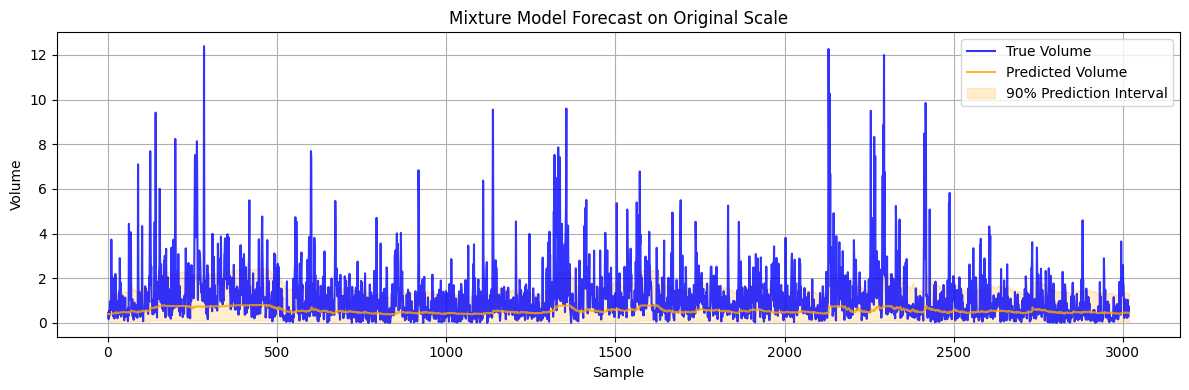

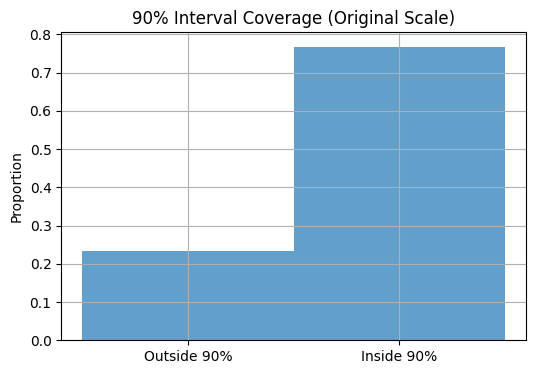

In [7]:
import numpy as np
import torch
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, r2_score
import properscoring as ps
import matplotlib.pyplot as plt

# --- Initialize accumulators ---
y_trues = []
y_preds = []
lower_intervals = []
upper_intervals = []
log_likelihoods = []
vars_list = []

# --- Evaluation loop ---
model.eval()
with torch.no_grad():
    for trx_batch, lob_batch, y in test_loader:
        trx_b = trx_batch.permute(0, 2, 1)
        lob_b = lob_batch.permute(0, 2, 1)

        # Forward pass: returns mean, var, alpha, threshold, prob
        mean, var, alpha, threshold, prob = model(trx_b, lob_b)

        # 1) Point prediction = mixture expectation of log-volume
        pred_log = torch.sum(mean * prob, dim=1)

        # 2) Mixture variance for prediction intervals:
        #    Var[Y] = E[σ² + μ²] - (E[μ])²
        second_moment = torch.sum(prob * (var + mean**2), dim=1)
        mixture_var = second_moment - pred_log**2
        mixture_std = torch.sqrt(torch.clamp(mixture_var, min=1e-6))

        # 90% Gaussian approx interval
        z = norm.ppf(0.95)
        lower = pred_log - z * mixture_std
        upper = pred_log + z * mixture_std

        # 3) Log-likelihood under the LNP mixture
        lnp = LNP(mean, torch.sqrt(var), alpha, threshold)
        log_pdf = lnp.log_pdf(y.unsqueeze(1))  # (batch,2)
        mix_ll = torch.sum(log_pdf * prob, dim=1)  # (batch,)

        # Collect
        y_trues.append(y.cpu().numpy())
        y_preds.append(pred_log.cpu().numpy())
        lower_intervals.append(lower.cpu().numpy())
        upper_intervals.append(upper.cpu().numpy())
        log_likelihoods.append(mix_ll.cpu().numpy())
        vars_list.append(var.cpu().numpy())

# --- Stack / concat ---
y_true = np.concatenate(y_trues)
y_pred = np.concatenate(y_preds)
lower = np.concatenate(lower_intervals)
upper = np.concatenate(upper_intervals)
log_likelihoods = np.concatenate(log_likelihoods)
var = np.concatenate(vars_list, axis=0)

print(f"y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}, var shape: {var.shape}")

# --- Back-transform to original scale ---
# De-normalize log-scale predictions and intervals
y_true_log = y_true * test_ds.y_std + test_ds.y_mean
y_pred_log = y_pred * test_ds.y_std + test_ds.y_mean
lower_log = lower * test_ds.y_std + test_ds.y_mean
upper_log = upper * test_ds.y_std + test_ds.y_mean

# Bias correction for back-transformation (using mixture variance)
mixture_var_denorm = var * (test_ds.y_std**2)  # Scale variance
mixture_std_denorm = np.sqrt(np.mean(mixture_var_denorm, axis=1))  # Average over mixture components
y_true_orig = np.exp(y_true_log)
y_pred_orig = np.exp(y_pred_log + 0.5 * mixture_std_denorm**2)  # Bias correction

# Back-transform intervals (approximate, assumes log-normal distribution)
lower_orig = np.exp(lower_log)
upper_orig = np.exp(upper_log)

# Validate data
if (y_true_orig <= 0).any():
    raise ValueError("y_true_orig contains non-positive values, invalid for log transformation.")

# --- Metrics on original scale ---
rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
r2_orig = r2_score(y_true_orig, y_pred_orig)
mape_orig = np.mean(np.abs((y_true_orig - y_pred_orig) / np.maximum(y_true_orig, 1e-6))) * 100
coverage_orig = np.mean((y_true_orig >= lower_orig) & (y_true_orig <= upper_orig))
crps_orig = np.mean([
    ps.crps_gaussian(y_true_orig[i], mu=y_pred_orig[i], sig=mixture_std_denorm[i])
    for i in range(len(y_true_orig))
])

# Log-scale metrics (for comparison)
rmse_log = np.sqrt(mean_squared_error(y_true, y_pred))
nll = -np.mean(log_likelihoods)
crps_log = np.mean([
    ps.crps_gaussian(y_true[i], mu=y_pred[i], sig=np.sqrt(var[i].mean()))
    for i in range(len(y_true))
])
coverage_log = np.mean((y_true >= lower) & (y_true <= upper))

print("Log-scale metrics:")
print(f"RMSE:         {rmse_log:.4f}")
print(f"NLL:          {nll:.4f}")
print(f"CRPS:         {crps_log:.4f}")
print(f"90% coverage: {coverage_log:.4f}")
print("\nOriginal-scale metrics:")
print(f"RMSE:         {rmse_orig:.4f}")
print(f"R²:           {r2_orig:.4f}")
print(f"MAPE:         {mape_orig:.2f}%")
print(f"CRPS:         {crps_orig:.4f}")
print(f"90% coverage: {coverage_orig:.4f}")

# --- Plots ---
# Original scale time series
plt.figure(figsize=(12, 4))
plt.plot(y_true_orig, label='True Volume', alpha=0.8, color='blue')
plt.plot(y_pred_orig, label='Predicted Volume', alpha=0.8, color='orange')
plt.fill_between(np.arange(len(y_true_orig)), lower_orig, upper_orig, 
                 alpha=0.2, color='orange', label='90% Prediction Interval')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Volume')
plt.title('Mixture Model Forecast on Original Scale')
plt.grid(True)
plt.tight_layout()

# Coverage histogram
plt.figure(figsize=(6, 4))
inside = ((y_true_orig >= lower_orig) & (y_true_orig <= upper_orig)).astype(int)
plt.hist(inside, bins=[0, 1, 2], density=True, alpha=0.7)
plt.xticks([0.5, 1.5], ['Outside 90%', 'Inside 90%'])
plt.ylabel('Proportion')
plt.title('90% Interval Coverage (Original Scale)')
plt.grid(True)

plt.show()

# UNDO the deses

Log-scale metrics:
RMSE:         1.1917
NLL:          2.6313
CRPS:         0.7001
90% coverage: 0.7668

Original-scale metrics:
RMSE:         1.3629
R²:           -0.2141
MAPE:         153.91%
CRPS:         0.6250
90% coverage: 0.7668

Final metrics (seasonality restored):
RMSE:         37.0447
R²:           -0.1448
MAPE:         153.91%
90% coverage: 0.7668


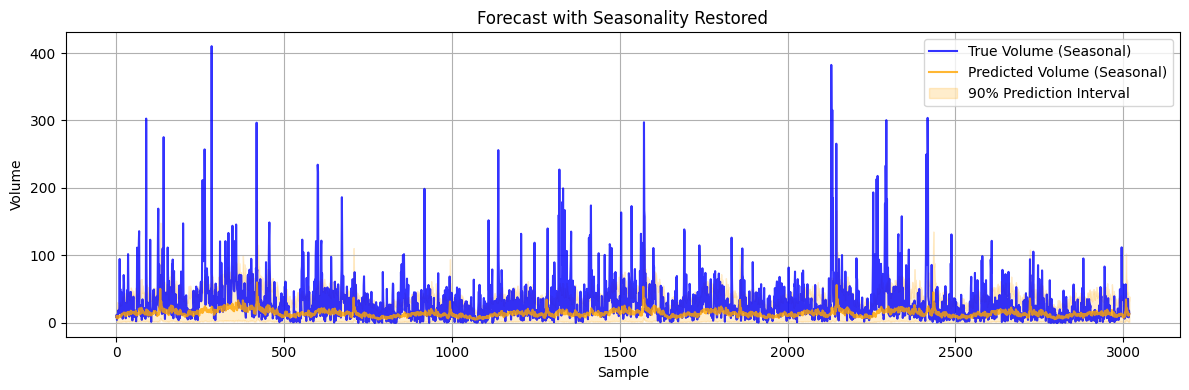

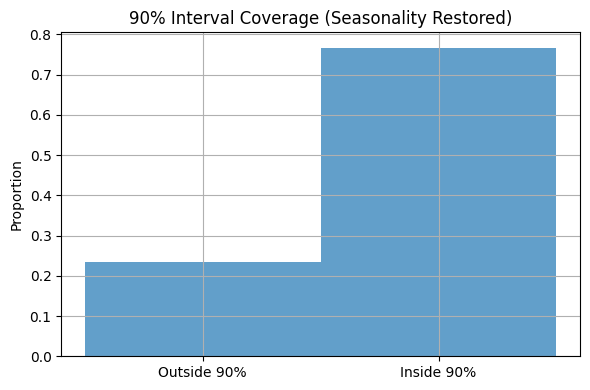

In [8]:
import numpy as np
import torch
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, r2_score
import properscoring as ps
import matplotlib.pyplot as plt

# --- Initialize accumulators ---
y_trues = []
y_preds = []
lower_intervals = []
upper_intervals = []
log_likelihoods = []
vars_list = []

# --- Evaluation loop ---
model.eval()
with torch.no_grad():
    for trx_batch, lob_batch, y in test_loader:
        trx_b = trx_batch.permute(0, 2, 1)
        lob_b = lob_batch.permute(0, 2, 1)

        # Forward pass: returns mean, var, alpha, threshold, prob
        mean, var, alpha, threshold, prob = model(trx_b, lob_b)

        # 1) Point prediction = mixture expectation of log-volume
        pred_log = torch.sum(mean * prob, dim=1)

        # 2) Mixture variance for prediction intervals:
        second_moment = torch.sum(prob * (var + mean**2), dim=1)
        mixture_var = second_moment - pred_log**2
        mixture_std = torch.sqrt(torch.clamp(mixture_var, min=1e-6))

        # 90% Gaussian approx interval
        z = norm.ppf(0.95)
        lower = pred_log - z * mixture_std
        upper = pred_log + z * mixture_std

        # 3) Log-likelihood under the LNP mixture
        lnp = LNP(mean, torch.sqrt(var), alpha, threshold)
        log_pdf = lnp.log_pdf(y.unsqueeze(1))  # (batch,2)
        mix_ll = torch.sum(log_pdf * prob, dim=1)  # (batch,)

        # Collect
        y_trues.append(y.cpu().numpy())
        y_preds.append(pred_log.cpu().numpy())
        lower_intervals.append(lower.cpu().numpy())
        upper_intervals.append(upper.cpu().numpy())
        log_likelihoods.append(mix_ll.cpu().numpy())
        vars_list.append(var.cpu().numpy())

# --- Stack / concat ---
y_true = np.concatenate(y_trues)
y_pred = np.concatenate(y_preds)
lower = np.concatenate(lower_intervals)
upper = np.concatenate(upper_intervals)
log_likelihoods = np.concatenate(log_likelihoods)
var = np.concatenate(vars_list, axis=0)

# --- Back-transform to original scale ---
y_true_log = y_true * test_ds.y_std + test_ds.y_mean
y_pred_log = y_pred * test_ds.y_std + test_ds.y_mean
lower_log = lower * test_ds.y_std + test_ds.y_mean
upper_log = upper * test_ds.y_std + test_ds.y_mean

mixture_var_denorm = var * (test_ds.y_std**2)
mixture_std_denorm = np.sqrt(np.mean(mixture_var_denorm, axis=1))
y_true_orig = np.exp(y_true_log)
y_pred_orig = np.exp(y_pred_log + 0.5 * mixture_std_denorm**2)
lower_orig = np.exp(lower_log)
upper_orig = np.exp(upper_log)

# --- Add seasonality back ---
mean_volume_test = test_df['mean_volume'].iloc[len(test_df) - len(y_true):].to_numpy()
y_true_seasonal = y_true_orig * mean_volume_test
y_pred_seasonal = y_pred_orig * mean_volume_test
lower_seasonal = lower_orig * mean_volume_test
upper_seasonal = upper_orig * mean_volume_test

# --- Metrics (log scale) ---
rmse_log = np.sqrt(mean_squared_error(y_true, y_pred))
nll = -np.mean(log_likelihoods)
crps_log = np.mean([ps.crps_gaussian(y_true[i], mu=y_pred[i], sig=np.sqrt(var[i].mean())) for i in range(len(y_true))])
coverage_log = np.mean((y_true >= lower) & (y_true <= upper))

# --- Metrics (original scale) ---
rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
r2_orig = r2_score(y_true_orig, y_pred_orig)
mape_orig = np.mean(np.abs((y_true_orig - y_pred_orig) / np.maximum(y_true_orig, 1e-6))) * 100
coverage_orig = np.mean((y_true_orig >= lower_orig) & (y_true_orig <= upper_orig))
crps_orig = np.mean([ps.crps_gaussian(y_true_orig[i], mu=y_pred_orig[i], sig=mixture_std_denorm[i]) for i in range(len(y_true_orig))])

# --- Metrics (seasonality restored) ---
rmse_seasonal = np.sqrt(mean_squared_error(y_true_seasonal, y_pred_seasonal))
r2_seasonal = r2_score(y_true_seasonal, y_pred_seasonal)
mape_seasonal = np.mean(np.abs((y_true_seasonal - y_pred_seasonal) / np.maximum(y_true_seasonal, 1e-6))) * 100
coverage_seasonal = np.mean((y_true_seasonal >= lower_seasonal) & (y_true_seasonal <= upper_seasonal))

# --- Print results ---
print("Log-scale metrics:")
print(f"RMSE:         {rmse_log:.4f}")
print(f"NLL:          {nll:.4f}")
print(f"CRPS:         {crps_log:.4f}")
print(f"90% coverage: {coverage_log:.4f}")

print("\nOriginal-scale metrics:")
print(f"RMSE:         {rmse_orig:.4f}")
print(f"R²:           {r2_orig:.4f}")
print(f"MAPE:         {mape_orig:.2f}%")
print(f"CRPS:         {crps_orig:.4f}")
print(f"90% coverage: {coverage_orig:.4f}")

print("\nFinal metrics (seasonality restored):")
print(f"RMSE:         {rmse_seasonal:.4f}")
print(f"R²:           {r2_seasonal:.4f}")
print(f"MAPE:         {mape_seasonal:.2f}%")
print(f"90% coverage: {coverage_seasonal:.4f}")

# --- Plot forecast with seasonality ---
plt.figure(figsize=(12, 4))
plt.plot(y_true_seasonal, label='True Volume (Seasonal)', alpha=0.8, color='blue')
plt.plot(y_pred_seasonal, label='Predicted Volume (Seasonal)', alpha=0.8, color='orange')
plt.fill_between(np.arange(len(y_true_seasonal)), lower_seasonal, upper_seasonal,
                 alpha=0.2, color='orange', label='90% Prediction Interval')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Volume')
plt.title('Forecast with Seasonality Restored')
plt.grid(True)
plt.tight_layout()

# --- Plot coverage ---
plt.figure(figsize=(6, 4))
inside = ((y_true_seasonal >= lower_seasonal) & (y_true_seasonal <= upper_seasonal)).astype(int)
plt.hist(inside, bins=[0, 1, 2], density=True, alpha=0.7)
plt.xticks([0.5, 1.5], ['Outside 90%', 'Inside 90%'])
plt.ylabel('Proportion')
plt.title('90% Interval Coverage (Seasonality Restored)')
plt.grid(True)
plt.tight_layout()
plt.show()
